# Source

## Core

**IMPORTS**

In [920]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import matplotlib.pyplot as plt
import random
import numpy as np
import torch
from torch import Tensor, nn
from torchvision.datasets import MNIST
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.transforms import ToTensor
from torch.distributions import Distribution
from torch.distributions import Bernoulli
from typing import Dict, Any
from torchvision import transforms
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler
import statistics
import math
import os.path
from torch.distributions import Categorical
# Static random seed
np.random.seed(89)

**LAMBDAS**

In [921]:
# Need to convert data to Tensor, because the DataLoader iterator refuses to work with PIL image objects.
pil2tensor = lambda x: ToTensor()(x).squeeze()   # ToTensor return (64,1,28,28), the squeeze() call removes the 1 dimension

# Binarize method for binarized dataset
binarize = lambda x: torch.bernoulli(x)

**DATASETS**

In [922]:
mnist_train_data = MNIST("./temp/", transform=pil2tensor, download=True, train=True)
mnist_test_data = MNIST("./temp/", transform=pil2tensor, download=True, train=False)

binarized_mnist_train_data = MNIST("./temp/",
                                   download=True,
                                   train=True,
                                   transform=transforms.Compose([pil2tensor,
                                                                 binarize]))
binarized_mnist_test_data = MNIST("./temp/",
                                  download=True,
                                  train=False,
                                  transform=transforms.Compose([pil2tensor,
                                                                binarize]))

**DATALOADERS**

In [1002]:
# QUESTION: Can we rely on the DataLoader to visit every contained sample over the course 
# of one epoch when using SubsetRandomSampler? If no, we should change something here...

# TODO: labelled data should contain same number of each digit, and set should be reduced from 10k to 100

# TODO: consider adding 'shuffle=True' to DataLoader, though unsure how interaction is with 
#       SubsetRandomSampler

# Initialize dataset indices
indices_train = list(range(len(binarized_mnist_train_data))) # 60000

# Split train into labelled, unlabelled and validation.
labelled_size = 10000
unlabelled_size = 40000
validation_size = 10000

# Shuffle dataset
np.random.shuffle(indices_train)

# Next, split the indices
labelled_idx = indices_train[:labelled_size]
unlabelled_idx = indices_train[labelled_size:labelled_size + unlabelled_size]
validation_idx = indices_train[labelled_size + unlabelled_size:]

# Last, generate the dataloaders
binarized_mnist_train_loader_labelled = DataLoader(binarized_mnist_train_data, 
                                                   batch_size = 64, 
                                                   sampler = SubsetRandomSampler(labelled_idx))
binarized_mnist_train_loader_unlabelled = DataLoader(binarized_mnist_train_data, 
                                                     batch_size = 64, 
                                                     sampler = SubsetRandomSampler(unlabelled_idx))
binarized_mnist_train_loader_validation = DataLoader(binarized_mnist_train_data, 
                                                     batch_size = 64, 
                                                     sampler = SubsetRandomSampler(validation_idx))

# Do not subdivide Test (this approach might be inappropriate when no intention to subdivide - check for better solution):
indices_test = list(range(len(binarized_mnist_test_data))) # 10000
binarized_mnist_test_loader = DataLoader(binarized_mnist_train_data, 
                                         batch_size = 64, 
                                         sampler = SubsetRandomSampler(indices_test))

In [924]:
# Non-binarized dataloader
indices_train = list(range(len(mnist_train_data))) # 60000
mnist_train_loader = DataLoader(mnist_train_data, 
                                batch_size = 64, 
                                sampler = SubsetRandomSampler(indices_train))

**REPARAMETERIZED DIAGONAL GUASSIAN**

In [925]:
# Implement reparameterized diagonal gaussian
#from torch.distributions import Distribution

class ReparameterizedDiagonalGaussian(Distribution):
    def __init__(self, mu: Tensor, log_sigma: Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        return self.mu + self.sigma*self.sample_epsilon()
        
    def log_prob(self, z:Tensor) -> Tensor:
        from torch.distributions import Normal 
        return  Normal(loc=self.mu, scale=self.sigma).log_prob(z)

**NETWORK CONSTRUCTOR HELPER**

In [926]:
def FF_NetworkConstructor(layers: [],
                          pre_batchnorm: bool,
                          hidden_batchnorm: bool,
                          hidden_activation,
                          final_activation) -> nn.Sequential:
    constructor = []
    if pre_batchnorm:
        constructor.append(nn.BatchNorm1d(num_features = layers[0]))
    for i in range(len(layers) - 2):
        constructor.append(nn.Linear(in_features = layers[i],
                                     out_features = layers[i + 1]))
        constructor.append(hidden_activation)
        if hidden_batchnorm:
            constructor.append(nn.BatchNorm1d(num_features = layers[i + 1]))
    
    constructor.append(nn.Linear(in_features = layers[-2], out_features = layers[-1]))
    if final_activation is not None:
        constructor.append(final_activation)
    result = nn.Sequential(*constructor)
    
    return result

**DATA ANALYSIS SUPPORT**

In [969]:
def confuse_matrix_update(predictions, labels, confusion_matrix):
    # Update 'confusion_matrix' according the the prodictions/labels vectors.
    # Confusion_matrix rows are actual labels, and columns predictions. E.g. row 0 
    # tells how the classifier predicted '0', (0,0) represents correct predictions, 
    # (0,1) is how many times a '0' was classified as a '1'
    for pre, lbl in zip(predictions, labels):
        confusion_matrix[lbl,pre] += 1
def confuse_matrix_accuracy(cm):
    return 0.0 if cm.sum() == 0 else cm.trace()/cm.sum()
if False:
    cm = np.zeros((10,10))
    pred=torch.tensor([2,9,8,6])
    lab =torch.tensor([2,9,8,4])
    confuse_matrix_update(pred,lab,cm)
    confuse_matrix_update(pred,lab,cm)
    print(cm, confuse_matrix_accuracy(cm))

In [998]:
def print_confuse_matrix(VAE, test_loader = binarized_mnist_test_loader):
    # print confuse_matrix for 'VAE' which is assumed to have function 'classifier'
    # and variable 'device' indicating cpu or cuda.
    confuse_matrix = np.zeros((10,10)).astype('int')
    for images_test,labels_test in test_loader:
        images_test = images_test.to(VAE.device)
        classifications = VAE.classifier(images_test.view(-1,28*28))
        preds = torch.argmax(classifications,1)
        confuse_matrix_update(preds, labels_test, confuse_matrix)
    print(confuse_matrix)
    print("Classifier accuracy: %.3f" % confuse_matrix_accuracy(confuse_matrix))

## Standard VAE

**VAE IMPLEMENTATION**

In [927]:
# Summarize values per sample
def reduce(x: Tensor) -> Tensor:
    return x.view(x.size(0), -1).sum(dim=1)

In [928]:
# Define hidden layer topology - list of sizes of hidden layers
encoder_dimensions = [512, 256, 128]
decoder_dimensions = [128, 256, 512]
apply_per_layer_batchnorm = False

# Implement VAE
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(VariationalAutoEncoder, self).__init__()

        # Core parameters
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        #self.prior_params = torch.zeros(torch.Size([1, 2*latent_features]))
        
        # Dynamically constructing the encoder network
        encoder_constructor = []
        encoder_constructor.append(nn.Linear(in_features=self.observation_features, out_features=encoder_dimensions[0]))
        encoder_constructor.append(nn.ReLU())
        if apply_per_layer_batchnorm:
            encoder_constructor.append(nn.BatchNorm1d(num_features=encoder_dimensions[0]))
        for i in range(len(encoder_dimensions)-1):
            encoder_constructor.append(nn.Linear(in_features=encoder_dimensions[i], out_features=encoder_dimensions[i+1]))
            encoder_constructor.append(nn.ReLU())
            if apply_per_layer_batchnorm:
                encoder_constructor.append(nn.BatchNorm1d(num_features=encoder_dimensions[i+1]))
        encoder_constructor.append(nn.Linear(in_features=encoder_dimensions[-1], out_features=2*self.latent_features))
        self.encoder = nn.Sequential(*encoder_constructor)

        # Dynamically constructing the decoder network
        decoder_constructor = []
        decoder_constructor.append(nn.Linear(in_features=self.latent_features, out_features=decoder_dimensions[0]))
        decoder_constructor.append(nn.ReLU())
        if apply_per_layer_batchnorm:
            decoder_constructor.append(nn.BatchNorm1d(num_features=decoder_dimensions[0]))
        for i in range(len(decoder_dimensions)-1):
            decoder_constructor.append(nn.Linear(in_features=decoder_dimensions[i], out_features=decoder_dimensions[i+1]))
            decoder_constructor.append(nn.ReLU())
            if apply_per_layer_batchnorm:
                decoder_constructor.append(nn.BatchNorm1d(num_features=decoder_dimensions[i+1]))
        decoder_constructor.append(nn.Linear(in_features=decoder_dimensions[-1], out_features=self.observation_features))
        self.decoder = nn.Sequential(*decoder_constructor)
    
    # Encode input into posterior distribution
    def encode(self, x: Tensor) -> Distribution:
        h_x = self.encoder(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    # Decode latent variables into reconstruction
    def decode(self, z: Tensor) -> Distribution:
        px_logits = self.decoder(z)
        px_logits = px_logits.view(-1, *self.input_shape)
        return Bernoulli(logits=px_logits)
    
    # Get the prior distribution
    def prior(self, batch_size: int = 1) -> Distribution:
        local_prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = local_prior_params.chunk(2, dim=-1)
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    # Sample from a provided distribution
    def sample(self, distribution: ReparameterizedDiagonalGaussian) -> Tensor:
        return distribution.rsample()
    
    # Compute the ELBO
    def elbo(self, prior: Distribution, posterior: Distribution, reconstruction: Distribution, x: Tensor, z: Tensor) -> float:
        tst = reconstruction.sample()
        x = x.view(x.size(0), -1)
        log_px = reduce(reconstruction.log_prob(x))
        log_pz = reduce(prior.log_prob(z))
        log_qz = reduce(posterior.log_prob(z))
        kl = log_qz - log_pz
        elbo = log_px - kl
        return elbo
    
    def forward(self, x: Tensor) -> Dict[str, Any]:
        # flatten the input
        x = x.view(x.size(0), -1)
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.encode(x)
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        # define the observation model p(x|z) = B(x | g(z))
        px = self.decode(z)
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}

**VAE TRAINER**

In [929]:
from torch import optim

class VAE_Trainer:
    def __init__(self, network: VariationalAutoEncoder, train: DataLoader, test: DataLoader):
        self.VAE = network
        self.train_data = train
        self.test_data = test
        if torch.cuda.is_available():
            self.device = "cuda:0"
            network.cuda()
        else:
            self.device = "cpu"
            network.cpu()
        self.optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
    
    def train(self):
        self.VAE.train()
        for images, labels in self.train_data:
            images = images.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.VAE(images)
            loss = -self.VAE.elbo(outputs['pz'], outputs['qz'], outputs['px'], images, outputs['z']).mean()
            loss.backward()
            self.optimizer.step()
    
    def test(self):
        self.VAE.eval()
        losses = []
        i = 0
        for images, labels in self.test_data:
            images = images.to(self.device)
            outputs = self.VAE(images)
            elbos = self.VAE.elbo(outputs['pz'], outputs['qz'], outputs['px'], images, outputs['z']).cpu().detach().numpy()
            losses = np.append(losses, elbos)
        loss = -np.mean(losses)
        print("Loss: ", loss)

## M2 VAE

**IMPLEMENTATION**

In [954]:
class M2_VAE(nn.Module):
    def __init__(self, 
                 input_shape: torch.Size,
                 latent_features: int,
                 classes: int, 
                 hidden_layers_preclass: [], 
                 hidden_layers_postclass: [], 
                 hidden_layers_classification: [],
                 hidden_layers_decoder: []):
        super(M2_VAE, self).__init__()
        
        # Core params
        self.input_shape = input_shape
        self.observation_features = np.prod(input_shape)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        self.register_buffer('classification_prior_params', torch.full(torch.Size([1, classes]), 1 / classes))
        self.classes = classes
        # Having epochs here makes it possible to continue training, with correct epochs counting
        self.epochs = 0
        
        # Cuda enabling
        if torch.cuda.is_available():
            self.use_cuda = True
            self.device = "cuda:0"
        else:
            self.use_cuda = False
            self.device = "cpu"
        
        # Classifier construction
        classifier_shape = [self.observation_features]
        classifier_shape.extend(hidden_layers_classification)
        classifier_shape.append(classes)
        self.classifier = FF_NetworkConstructor(layers = classifier_shape,
                                                pre_batchnorm = False,
                                                hidden_batchnorm = True,
                                                hidden_activation = nn.ReLU(),
                                                final_activation = nn.Softmax(1))
        
        # Pre-classification network construction
        preclass_shape = [self.observation_features]
        preclass_shape.extend(hidden_layers_preclass)
        self.preclass_encoder = FF_NetworkConstructor(layers = preclass_shape,
                                                      pre_batchnorm = False,
                                                      hidden_batchnorm = True,
                                                      hidden_activation = nn.ReLU(),
                                                      final_activation = nn.ReLU())
        
        # Post-classification network construction
        postclass_shape = [hidden_layers_preclass[-1] + classes]
        postclass_shape.extend(hidden_layers_postclass)
        postclass_shape.append(latent_features * 2)
        self.postclass_encoder = FF_NetworkConstructor(layers = postclass_shape,
                                                       pre_batchnorm = False,
                                                       hidden_batchnorm = True,
                                                       hidden_activation = nn.ReLU(),
                                                       final_activation = None)
        
        # Decoder construction
        decoder_shape = [latent_features + classes]
        decoder_shape.extend(hidden_layers_decoder)
        decoder_shape.append(self.observation_features)
        self.decoder = FF_NetworkConstructor(layers = decoder_shape,
                                             pre_batchnorm = False,
                                             hidden_batchnorm = True,
                                             hidden_activation = nn.ReLU(),
                                             final_activation = None)
        
        # Move networks to cuda if available
        if self.use_cuda:
            self.classifier.cuda()
            self.preclass_encoder.cuda()
            self.postclass_encoder.cuda()
            self.decoder.cuda()
    
    def prior(self, batch_size: int = 1) -> Distribution:
        local_prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = local_prior_params.chunk(2, dim=-1)
        result = ReparameterizedDiagonalGaussian(mu, log_sigma)
        result.mu = result.mu.to(self.device)
        result.sigma = result.sigma.to(self.device)
        return result
    
    def classification_prior(self, batch_size: int = 1) -> Distribution:
        local_classification_prior_params = self.classification_prior_params.expand(batch_size, 
                                                                                    *self.classification_prior_params.shape[-1:])
        result = Categorical(probs = local_classification_prior_params)
        return result
    
    def classification_posterior(self, x: Tensor) -> Distribution:
        result = self.classifier(x)
        result = result.view(-1, self.classes)
        result = Categorical(logits = result)
        return result
    
    def classification_entropy(self, qy: Tensor) -> float:
        qy = qy * torch.log(qy)
        return -qy.sum()
        
    def encode(self, x: Tensor, y: Tensor = None) -> Tensor:
        # Classify if no classification is provided
        if y is None:
            y = self.classifier(x)
        # Encode input
        result = self.preclass_encoder(x)
        result = torch.cat((result, y), 1)
        result = self.postclass_encoder(result)
        mu, log_sigma =  result.chunk(2, dim=-1)
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def decode(self, z: Tensor, y: Tensor) -> Distribution:
        px_logits = self.decoder(torch.cat((z, y), 1))
        px_logits = px_logits.view(-1, *self.input_shape)
        return Bernoulli(logits = px_logits)
    
    def onehot(self, y: int):
        result = torch.zeros(y.shape[0], self.classes).to(self.device)
        for i in range(len(y)):
            result[i][y[i]] = 1
        return result
    
    def loss(self,
             px: Distribution, 
             py: Distribution, 
             pz: Distribution, 
             qy: Distribution, 
             qz: Distribution, 
             x: Tensor,
             y: int, 
             z: Tensor,
             alpha: float) -> float:
        x = x.to(self.device)
        y = y.to(self.device)
        z = z.to(self.device)
        # If labels are not provided, sample from classification posterior
        if y is None:
            classified = False
        else:
            classified = True
            y = y.view(-1, 1)
        
        x = x.view(x.size(0), -1)
        px_logprob = px.log_prob(x).sum(dim = 1).view(-1, 1).repeat(1, 10)
        py_logprob = py.logits.to(self.device)
        pz_logprob = pz.log_prob(z).sum(dim = 1).view(-1, 1).repeat(1, 10)
        qz_logprob = qz.log_prob(z).sum(dim = 1).view(-1, 1).repeat(1, 10)
        L = -(px_logprob + py_logprob + pz_logprob - qz_logprob)
        if classified:
            J = L.gather(1, y)
            J_alpha = J - (alpha * qy.logits.gather(1, y))
            return J_alpha
        else:
            U = -(torch.mul(qy.probs, L).sum(1) + self.classification_entropy(qy.probs))
            J = U
            return J
    
    def forward(self, x: Tensor, y: int = None) -> Dict[str, Any]:
        x = x.to(self.device) # Move to cuda if applicable
        y = y.to(self.device)
        x = x.view(x.size(0), -1) # Flatten image input
        qy = self.classification_posterior(x) # Classification posterior q(y|x)
        if y is None: # If labels are not provided, sample from classification posterior
            y = qy.sample()
        else:
            y = self.onehot(y)
        py = self.classification_prior(batch_size = x.size(0)) # Classification prior p(y)
        qz = self.encode(x, y) # Approximate posterior q(z|x, y)
        pz = self.prior(batch_size=x.size(0)) # Prior p(z)
        z = qz.rsample()# Sample the posterior
        px = self.decode(z, y) # Reconstruction p(x|z, y) = B(x | g(z, y))
        return {'px': px, 'py': py, 'pz': pz, 'qy': qy, 'qz': qz, 'z': z}

**TRAINER**

In [977]:
class M2_VAE_Trainer:
    def __init__(self, network: M2_VAE, train: DataLoader, test: DataLoader, alpha: float):
        self.model = network
        self.train_data = train
        self.test_data = test
        self.alpha = alpha
        self.training_data = defaultdict(list)
        self.validation_data = defaultdict(list)
        self.optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
    
    def train(self):
        self.model.train()
        for images, labels in self.train_data:
            self.optimizer.zero_grad()
            outputs = self.model(images, labels)
            loss = self.model.loss(outputs['px'], 
                                   outputs['py'], 
                                   outputs['pz'], 
                                   outputs['qy'], 
                                   outputs['qz'],
                                   images, 
                                   labels,
                                   outputs['z'],
                                   self.alpha).mean()
            loss.backward()
            self.optimizer.step()
        self.model.epochs += 1
    
    def test(self):
        self.model.eval()
        losses = []
        i = 0
        epoch_data = defaultdict(list)
        confuse_matrix = np.zeros((10,10)).astype('int')
        for images, labels in self.test_data:
            outputs = self.model(images, labels)
            loss = self.model.loss(outputs['px'], 
                                        outputs['py'], 
                                        outputs['pz'], 
                                        outputs['qy'], 
                                        outputs['qz'],
                                        images, 
                                        labels,
                                        outputs['z'],
                                        self.alpha).mean()
            epoch_data['loss'] += [loss.item()]

            classifications = self.model.classifier(images.view(-1,28*28).to(self.model.device))
            preds = torch.argmax(classifications,1)
            confuse_matrix_update(preds, labels, confuse_matrix)

        for k, v in epoch_data.items():
            self.validation_data[k] += [np.mean(v)]
        self.validation_data['class_accu'] += [confuse_matrix_accuracy(confuse_matrix)]

        print("epoch=%d  test_loss=%.2f  class_accu=%.3f" % (self.model.epochs, 
                                                             self.validation_data['loss'][-1], 
                                                             self.validation_data['class_accu'][-1]))


# Subtasks

**SUBTASK 2.1.2: Plot 8x8 random samples from MNIST data**

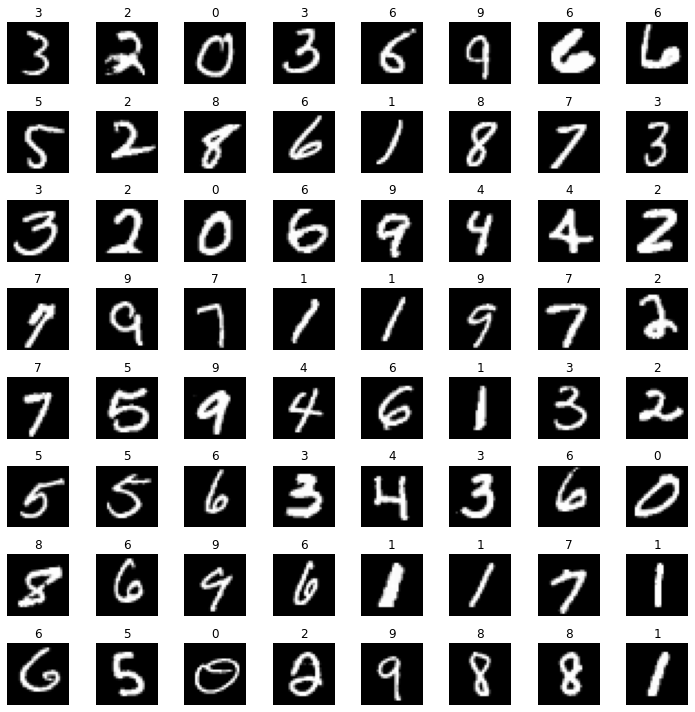

In [932]:
images, labels = next(iter(mnist_train_loader))

fig, axs = plt.subplots(8, 8, figsize=(10, 10), squeeze=False)
i = 0
for ax in axs.flat:
    ax.imshow(images[i], cmap='gray')
    ax.set_title("%s" % (labels[i].item()))
    ax.axis('off')
    i += 1
plt.tight_layout()

**SUBTASK 2.1.4: Plot binarized MNIST samples**

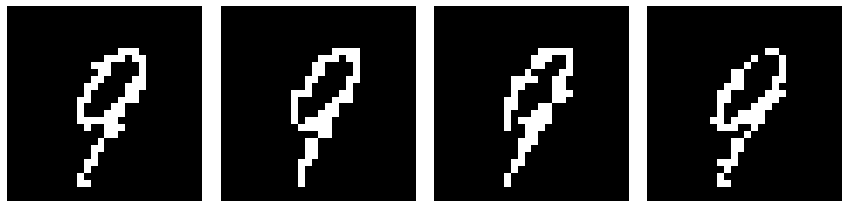

In [933]:
# Plot same image a couple of times to verify we are doing statistical sampling every time the image is drawn
fig, axs = plt.subplots(1, 4, figsize=(12, 3), squeeze=False)
for ax in axs.flat:
    sample = binarized_mnist_train_data.__getitem__(22)[0]
    assert torch.max(sample) == 1.0
    assert torch.min(sample) == 0.0
    ax.imshow(sample, cmap='gray')
    ax.axis('off')
plt.tight_layout()

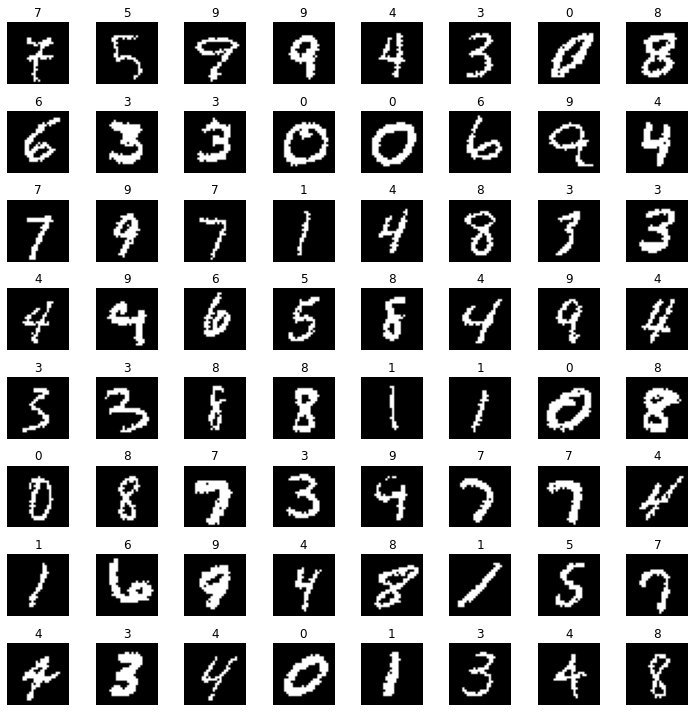

In [934]:
images, labels = next(iter(binarized_mnist_train_loader_labelled))
fig, axs = plt.subplots(8, 8, figsize=(10, 10), squeeze=False)
i = 0
for ax in axs.flat:
    ax.imshow(images[i], cmap='gray')
    ax.set_title("%s" % (labels[i].item()))
    ax.axis('off')
    i += 1
plt.tight_layout()

**SUBTASK 2.2.1.2: Print samples from untrained VAE**

In [935]:
# Instantiate a VAE
sample = binarized_mnist_train_data.__getitem__(0)[0]
testVAE = VariationalAutoEncoder(sample.flatten().shape, 5)

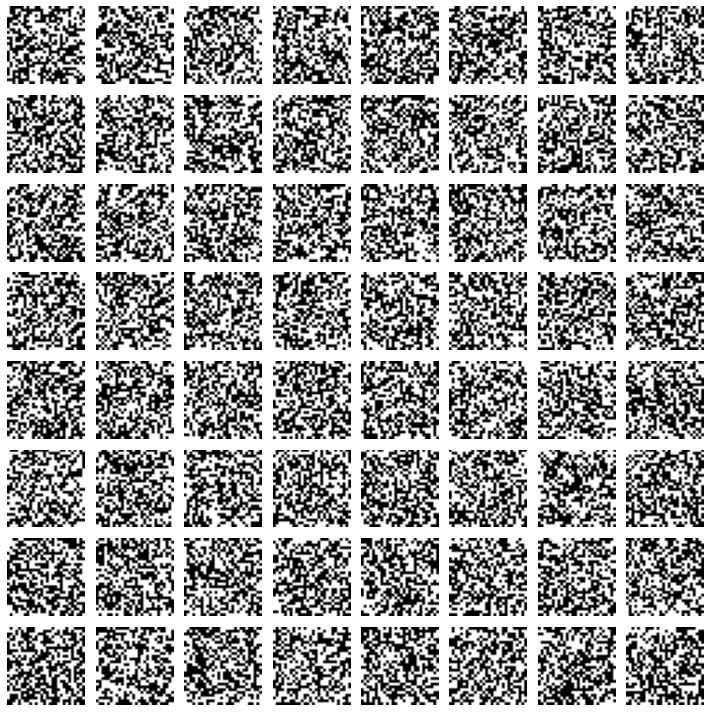

In [936]:
# Method 1: Decoding sample from prior
testVAE.cpu()
testVAE.eval()

prior = testVAE.prior(64)
prior_sample = testVAE.sample(prior)
decoded_prior_sample = testVAE.decode(prior_sample)
sampled_decode_content = decoded_prior_sample.sample().view(64, 28, 28)

fig, axs = plt.subplots(8, 8, figsize=(10, 10), squeeze=False)
i = 0
for ax in axs.flat:
    ax.imshow(sampled_decode_content[i], cmap='gray')
    ax.axis('off') 
    i += 1
plt.tight_layout()

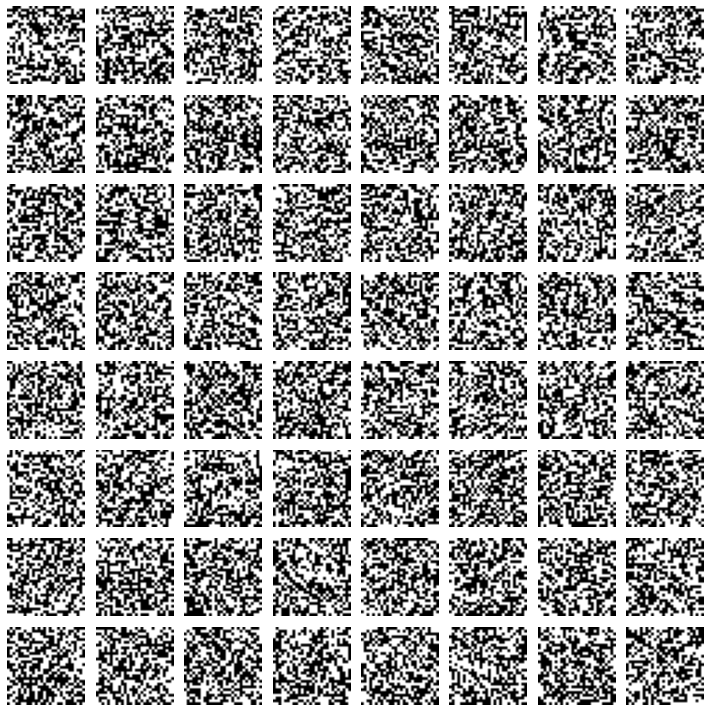

In [937]:
# Method 2: Reconstruction of input from binarized MNIST
a = random.choices(binarized_mnist_train_data,k=64)
b = [x[0] for x in a]
img = torch.stack(b)
sampled_decode_content = testVAE(img)['px'].sample().view(-1,28,28)

fig, axs = plt.subplots(8, 8, figsize=(10, 10), squeeze=False)
i = 0
for ax in axs.flat:
    ax.imshow(sampled_decode_content[i], cmap='gray')
    ax.axis('off') 
    i += 1
plt.tight_layout()

**2.2.1.3: Compute ELBO of 64 samples**

In [938]:
sample_cnt = 64
samples = np.zeros(shape=(sample_cnt, 784))
labels = np.zeros(shape=(sample_cnt, 1))
for i in range(sample_cnt):
    sample = random.choice(binarized_mnist_train_data)
    samples[i] = sample[0].view(1, -1).numpy()
    labels[i] = sample[1]

prior = testVAE.prior(sample_cnt)
samples_tensor = Tensor(samples)
posterior = testVAE.encode(samples_tensor)
z = testVAE.sample(posterior) # Random sampling
reconstruction = testVAE.decode(z)
elbo = testVAE.elbo(prior, posterior, reconstruction, samples_tensor, z) 

# 'float64' required because 'stdev' chokes on 'float32' which is the default type when detaching from GPU
elbo_ary = elbo.detach().numpy().astype('float64')
elbo_stddev = statistics.stdev(elbo_ary)
elbo_mean = statistics.mean(elbo_ary)
print("ELBO on %d train data: %.1f +/-%.1f" % (sample_cnt, elbo_mean,elbo_stddev))

ELBO on 64 train data: -544.1 +/-0.8


**2.2.2.3: Training the network**


In [939]:
%%time
#binarized_mnist_test_loader = DataLoader(binarized_mnist_test_data, batch_size = 64)
trainer = VAE_Trainer(testVAE, binarized_mnist_train_loader, binarized_mnist_test_loader)

testVAE_fn = "./M1_119ls_base_200ep.pt"
if os.path.isfile(testVAE_fn):
    testVAE.load_state_dict(torch.load(testVAE_fn))
    print("Loaded testVAE model from %s" % testVAE_fn)
    trainer.test()
else:
    epochs = 200
    for i in range(epochs):
        print("Training epoch ", i)
        trainer.train()
        print("Testing epoch ", i)
        trainer.test()
    torch.save(testVAE.state_dict(), testVAE_fn)

Loaded testVAE model from ./M1_119ls_base_200ep.pt
Loss:  112.5633602443695
Wall time: 2.11 s


**2.2.2.4: Generating samples from trained model**

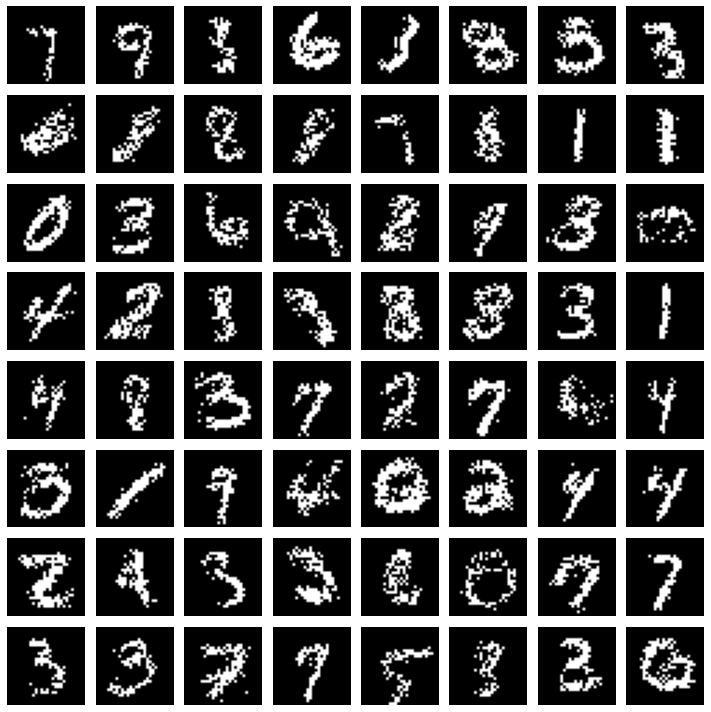

In [940]:
testVAE.cpu()
testVAE.eval()

prior = testVAE.prior(64)
prior_sample = testVAE.sample(prior)
decoded_prior_sample = testVAE.decode(prior_sample)
sampled_decode_content = decoded_prior_sample.sample().view(64, 28, 28)

fig, axs = plt.subplots(8, 8, figsize=(10, 10), squeeze=False)
i = 0
for ax in axs.flat:
    ax.imshow(sampled_decode_content[i], cmap='gray')
    ax.axis('off') 
    i += 1
plt.tight_layout()

In [941]:
sample_cnt = binarized_mnist_test_data.data.shape[0]
#sample_cnt = 100
samples_tensor = torch.empty(sample_cnt,28,28)
for idx in range(samples_tensor.shape[0]):
    samples_tensor[idx] = binarized_mnist_test_data[idx][0]

prior = testVAE.prior(sample_cnt)
samples_tensor = samples_tensor.view(sample_cnt,-1)
samples_tensor.shape
posterior = testVAE.encode(samples_tensor)
z = testVAE.sample(posterior)
reconstruction = testVAE.decode(z)
elbo = testVAE.elbo(prior, posterior, reconstruction, samples_tensor, z) 

# 'float64' required because 'stdev' chokes on 'float32' which is the default type when detaching from GPU
elbo_ary = elbo.detach().numpy().astype('float64')
elbo_stddev = statistics.stdev(elbo_ary)
elbo_mean = statistics.mean(elbo_ary)
print("ELBO on %d test data: %.1f +/-%.1f" % (sample_cnt, elbo_mean,elbo_stddev))

ELBO on 10000 test data: -118.8 +/-45.2


**2.3.1: Extracting 10 samples per class for classification training**

**ToDo:** Consider more elegant solution for classification_sampler

In [942]:
from torch.utils.data.sampler import SubsetRandomSampler
import functools

def classification_sampler(labels):
    indices = []
    for i in range(10):
        #(tmp_indices,) = np.where(functools.reduce(lambda x, y: x | y, [labels.numpy() == i]))
        tmp_indices = np.where(labels.numpy() == i)[0]
        indices.append(random.choices(tmp_indices, k=10))
    indices = torch.Tensor(indices)
    indices = indices.view(1, -1).squeeze().int()
    return SubsetRandomSampler(indices)
    
classification_loader = DataLoader(binarized_mnist_train_data, batch_size=25,
                                   sampler=classification_sampler(binarized_mnist_train_data.train_labels))
# Accuracy of Test Accuracy estimates based on batch_size
#  10k: baseline
# 2000: 0.5% 0.9% 1.6%
# 5000: 0.2% 0.9% 1.2%
# Adding 2.5 sec by using all test data instead of just 1000. Worth the price.
classification_loader_test = DataLoader(binarized_mnist_test_data, shuffle=True, batch_size=10000)

C:\Users\axbr\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


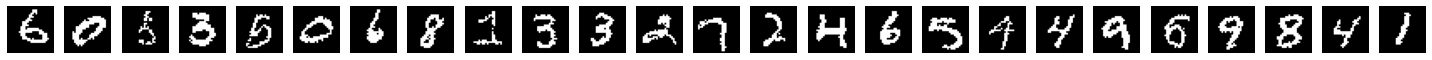

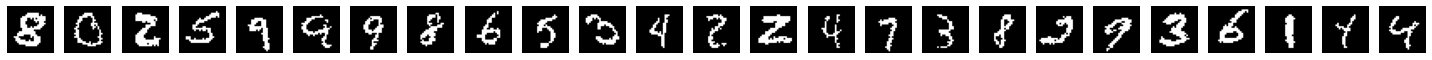

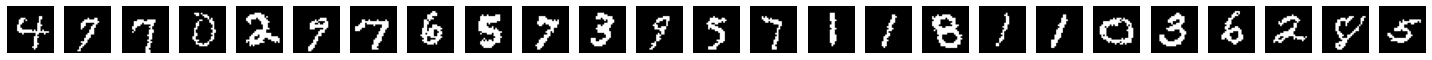

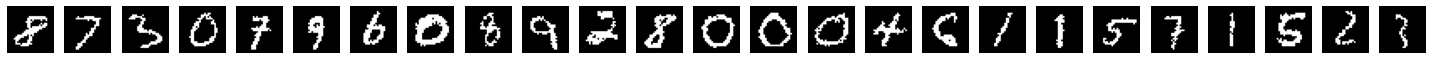

In [943]:
# visual check that the same 100 pictures are printed, and only permutated. Evaluate this cell a couple of times.
for images, labels in classification_loader:
    fig, axs = plt.subplots(1, 25, figsize=(20, 25), squeeze=False)
    for i,ax in enumerate(axs.flat):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off') 
    plt.tight_layout()

**2.3.2: Training classifier on latent representation**

In [944]:
# Define a classification model

class LatentClassifier(nn.Module):
    def __init__(self, latent_features:int) -> None:
        super(LatentClassifier, self).__init__()
        self.model = nn.Sequential(nn.BatchNorm1d(latent_features*2),    # MAGIC! raises accurcay from 50% to 75%
                                   nn.Linear(in_features=latent_features*2, out_features=10), 
                                   nn.Sigmoid(),  # Initial network used ReLU in output layer, however this was prone to give
                                                  # dead outputs, eg. classifier would often train so some classes would 
                                                  # never be guessed
                                   nn.Dropout(p=0.5)        # raises accuracy from 75% to 83%
                                  )
        
    def forward(self, x) -> Tensor:
        x = self.model(x)
        return x

In [945]:
# This class builds a M1 classifier. Output is logits tensor. UNDER CONSTRUCTION.
class M1Classifier(nn.Module):
    def __init__(self, VAE: nn.Module, LatentClassifier: nn.Module) -> None:
        super(M1Classifier, self).__init__()
        self.VAE = VAE
        self.LatentClassifier = LatentClassifier
        

In [946]:
def do_test_eval(cnt, epochs, num_of_evals):
    # Used for doing occasional print of test evaluation data.
    # Return true 'num_of_evals' times when running range(epochs) training
    # Will also trigger at start and end
    modulu = math.ceil(epochs/(num_of_evals-1))
    return cnt==0 or cnt==epochs-1 or cnt % modulu == modulu-1

In [948]:
%%time
testVAE.eval()

testLC = LatentClassifier(5)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(testLC.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(testLC.parameters(), lr=0.005)


epochs = 200
images_test, labels_test = next(iter(classification_loader_test))

for epoch in range(epochs):
    # Training
    testLC.train()
    for images, labels in classification_loader:
        outputs = testVAE(images)
        classifier_input = torch.cat((outputs['qz'].mu, outputs['qz'].sigma), 1)
        optimizer.zero_grad()
        classifications = testLC(classifier_input)
        loss = criterion(classifications, labels)
        loss.backward()
        optimizer.step()
    
    # Evaluating
    if do_test_eval(epoch,epochs,10):
        testLC.eval()
        confuse_matrix = np.zeros((10,10)).astype('int')
        outputs = testVAE(images_test)
        classifier_input = torch.cat((outputs['qz'].mu, outputs['qz'].sigma), 1)
        classifications = testLC(classifier_input)
        preds = torch.max(classifications, 1)[1]
        confuse_matrix_update(preds, labels_test, confuse_matrix)
        accuracy = confuse_matrix_accuracy(confuse_matrix)
        print("Epoch %3d, train loss %.3f, test accuracy: %.3f" % (epoch, loss.item(), accuracy))
print()
print(confuse_matrix)

Epoch   0, train loss 2.289, test accuracy: 0.032
Epoch  22, train loss 2.076, test accuracy: 0.631
Epoch  45, train loss 2.158, test accuracy: 0.730
Epoch  68, train loss 2.080, test accuracy: 0.729
Epoch  91, train loss 1.889, test accuracy: 0.730
Epoch 114, train loss 1.700, test accuracy: 0.734
Epoch 137, train loss 2.006, test accuracy: 0.746
Epoch 160, train loss 1.710, test accuracy: 0.745
Epoch 183, train loss 1.721, test accuracy: 0.740
Epoch 199, train loss 1.781, test accuracy: 0.755

[[841   0  62   2   0  13   1   1  60   0]
 [ 15 956   7  44   4  13  24  66   6   0]
 [ 21   0 853  70  17   0  49   3  14   5]
 [  3   1 103 764   2  25   0   7  98   7]
 [  2   3   1   1 664   0  37   3   8 263]
 [104   0  21  25   3 631   4  32  57  15]
 [125   1   9   1 125   2 682   1   3   9]
 [  2   0   5  12  32   0   2 619  22 334]
 [ 14   0  76 128   1  14   3   0 677  61]
 [  5   2   6  16  56   4   5  20  28 867]]
Wall time: 7.83 s


In [949]:
classification_loader = DataLoader(binarized_mnist_train_data, batch_size=100,
                                   sampler=classification_sampler(binarized_mnist_train_data.train_labels))
optimizer = optim.Adam(testLC.parameters(), lr=0.0005)
for epoch in range(epochs):
    # Training
    testLC.train()
    for images, labels in classification_loader:
        outputs = testVAE(images)
        classifier_input = torch.cat((outputs['qz'].mu, outputs['qz'].sigma), 1)
        optimizer.zero_grad()
        classifications = testLC(classifier_input)
        loss = criterion(classifications, labels)
        loss.backward()
        optimizer.step()
    
    # Evaluating
    if do_test_eval(epoch,epochs,10):
        testLC.eval()
        confuse_matrix = np.zeros((10,10)).astype('int')
        outputs = testVAE(images_test)
        classifier_input = torch.cat((outputs['qz'].mu, outputs['qz'].sigma), 1)
        classifications = testLC(classifier_input)
        preds = torch.max(classifications, 1)[1]
        confuse_matrix_update(preds, labels_test, confuse_matrix)
        accuracy = confuse_matrix_accuracy(confuse_matrix)
        print("Epoch %3d, train loss %.3f, test accuracy: %.3f" % (epoch, loss.item(), accuracy))
print()
print(confuse_matrix)

Epoch   0, train loss 1.847, test accuracy: 0.756
Epoch  22, train loss 1.862, test accuracy: 0.758
Epoch  45, train loss 1.645, test accuracy: 0.763
Epoch  68, train loss 1.695, test accuracy: 0.769
Epoch  91, train loss 1.733, test accuracy: 0.773
Epoch 114, train loss 1.850, test accuracy: 0.776
Epoch 137, train loss 1.661, test accuracy: 0.779
Epoch 160, train loss 1.710, test accuracy: 0.782
Epoch 183, train loss 1.767, test accuracy: 0.785
Epoch 199, train loss 1.797, test accuracy: 0.786

[[ 868    0   71    2    0    5    1    1   32    0]
 [  25 1019    7   41    2   11   19    6    5    0]
 [  23    0  938   19    2    0   33    2   10    5]
 [   4    3  120  763    2   30    0    5   80    3]
 [   2    8   10    1  700    0   42    2    9  208]
 [  84    1   15   37    1  683    5   21   37    8]
 [ 105    2   11    0   97    2  737    1    3    0]
 [   1    4    8   15   27    1    2  591   34  345]
 [  16    0  118   99    0   14    2    0  690   35]
 [   6    4   15   19 

Cells notes:
Initial results showed large accuracy variation, varying from 0.40 to 0.73 accuracy. Confusion matrix revealed that some numbers were never chosen. E.g. below where classifier never outputs a '9' classification.
<code>
[[464   0  12   5   0   2   9   0   0   0]
 [  0 489   2   9   3   1  39  22   0   0]
 [  6   1 484   4   5   0   1   7  10   0]
 [  2   1  13 361   3  15   7   8  86   0]
 [  1   0   7   3 418   4   3  43   4   0]
 [ 17   1   4  17   4 389  15   8   4   0]
 [ 80   3  49   0   1  24 327   0   0   0]
 [  0   6   9   5   8   1   7 468   1   0]
 [  4   1  95  29  14  17   7  10 328   0]
 [  0   1  33  65 100   0   2 175 117   0]]
</code>

**2.3.3: Classifying MNIST using simple FFNN**

In [950]:
# Define a classification model

class SimpleClassifier(nn.Module):
    def __init__(self, input_shape: int) -> None:
        super(SimpleClassifier, self).__init__()
        self.model = nn.Sequential(nn.BatchNorm1d(input_shape),
                                   nn.Linear(in_features=input_shape, out_features=10),
                                   nn.Dropout(p=0.5),   # raises from 66% to 70%
                                   nn.Sigmoid(),
                                  )
        
    def forward(self, x) -> Tensor:
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

In [951]:
classification_loader = DataLoader(binarized_mnist_train_data, batch_size=100,
                                   sampler=classification_sampler(binarized_mnist_train_data.train_labels))

testSC = SimpleClassifier(784)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(testSC.parameters(), lr=0.001)


epochs = 200
for epoch in range(epochs):
    # Training
    testSC.train()
    for images, labels in classification_loader:
        optimizer.zero_grad()
        classifications = testSC(images)
        loss = criterion(classifications, labels)
        loss.backward()
        optimizer.step()
    
    # Evaluating
    if do_test_eval(epoch,epochs,10):
        testSC.eval()
        confuse_matrix = np.zeros((10,10)).astype('int')
        classifications = testSC(images_test)
        preds = torch.max(classifications, 1)[1]
        confuse_matrix_update(preds, labels_test, confuse_matrix)
        accuracy = confuse_matrix_accuracy(confuse_matrix)
        print("Epoch %3d, train loss %.3f, test accuracy: %.3f" % (epoch, loss.item(), accuracy))
print()
print(confuse_matrix)

Epoch   0, train loss 2.302, test accuracy: 0.165
Epoch  22, train loss 2.053, test accuracy: 0.679
Epoch  45, train loss 1.991, test accuracy: 0.697
Epoch  68, train loss 1.940, test accuracy: 0.677
Epoch  91, train loss 1.931, test accuracy: 0.646
Epoch 114, train loss 1.923, test accuracy: 0.640
Epoch 137, train loss 1.914, test accuracy: 0.644
Epoch 160, train loss 1.898, test accuracy: 0.644
Epoch 183, train loss 1.957, test accuracy: 0.649
Epoch 199, train loss 1.907, test accuracy: 0.645

[[ 668    4    2    3    2  191   22   82    5    1]
 [   0 1083    4    1    0   14   16    3   14    0]
 [  84  132  582   56    8   49   24   34   47   16]
 [  77   24   32  629    6  129   34   32   22   25]
 [  33   24   10   15  535   18   40   34   18  255]
 [ 101   31    3   74   27  517   39   16   66   18]
 [ 102   27   13    6   16   55  636   99    2    2]
 [ 163   36   18   13    4   14   33  624    8  115]
 [  70   59    8   74   26   51   26    8  623   29]
 [  99   19    3   12 

Notes: training results are noise, rerunning training can give from 64% to 69%. Thus at least 3 restarts must be done to determine is a change was beneficial. With only single-layer FFNN I have difficulty getting above 69%. The dropout layer on the output improves results from 65% to 69%. This is surprising for me, because in the output layer each node is necessary, because it is needed to identify one digit.

**2.4: M2 implementation**

In [978]:
sample = binarized_mnist_train_data.__getitem__(22)[0]
TestM2 = M2_VAE(sample.flatten().shape, # Input shape
                20, # Latent features
                10, # Classes
                [200], # Network dimensions for encoder before adding classifications
                [100], # Network dimensions for encoder after adding classification
                [200, 100], # Network dimensions for classification network
                [200, 300, 400, 500]) # Network dimensions for decoder
print(TestM2)

M2_VAE(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=200, out_features=100, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=100, out_features=10, bias=True)
    (7): Softmax(dim=1)
  )
  (preclass_encoder): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): ReLU()
  )
  (postclass_encoder): Sequential(
    (0): Linear(in_features=210, out_features=100, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=100, out_features=40, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=200, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, af

In [1000]:
%%time
trainer = M2_VAE_Trainer(TestM2, binarized_mnist_train_loader_labelled, binarized_mnist_test_loader, 0.1)

epochs = 2
fn = "./M2_ok_%dep.pt" % epochs
if False and os.path.isfile(fn):
    TestM2.load_state_dict(torch.load(fn))
    print("Loaded model from %s" % fn)
    trainer.test()
else:
    trainer.test()
    for i in range(epochs):
        trainer.train()
        trainer.test()
    torch.save(TestM2.state_dict(), fn)

epoch=11  test_loss=111.91  class_accu=0.957
epoch=12  test_loss=110.93  class_accu=0.958
epoch=13  test_loss=110.26  class_accu=0.960
Wall time: 17.7 s


In [1001]:
print_confuse_matrix(TestM2)

[[ 976    0    2    1    1   10    5    1    3    2]
 [   0 1101    6    2    4    1    0    2    9    2]
 [   3    7  956    8    6    2    2    3    3    1]
 [   1    3   13  978    1    8    1   13   10    4]
 [   0    0    2    0  962    0    2    2    1   11]
 [   3    0    1    7    5  830    4    1    5    7]
 [   3    2    5    2    4   13  975    2    8    0]
 [   0    4    8    1    5    1    0 1040    1   10]
 [   3    3   19   11    7    6    4    1  888    2]
 [   4    1    1   11   30    0    1   21    5  904]]
Classifier accuracy: 0.961
